### Requirements

In [2]:
!conda install -y sentence-transformers

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2



## Package Plan ##

  environment location: /Users/i.kuryanov/miniforge3/envs/katja

  added / updated specs:
    - sentence-transformers


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aiohappyeyeballs-2.4.3     |     pyhd8ed1ab_0          19 KB  conda-forge
    aiohttp-3.11.2             |  py312h998013c_0         845 KB  conda-forge
    attrs-24.2.0               |     pyh71513ae_0          55 KB  conda-forge
    aws-c-auth-0.8.0           |       h6935006_7          90 KB  conda-forge
    aws-c-cal-0.8.0            |       h8a8b6a7_1          39 KB  conda-forge
    aws-

In [5]:
!conda install -y rouge

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2



## Package Plan ##

  environment location: /Users/i.kuryanov/miniforge3/envs/katja

  added / updated specs:
    - rouge


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    rouge-1.0.1                |     pyhd8ed1ab_0          18 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          18 KB

The following NEW packages will be INSTALLED:

  rouge              conda-forge/noarch::rouge-1.0.1-pyhd8ed1ab_0 



                                                                                
Prepari

In [7]:
!conda install -y nltk

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2



## Package Plan ##

  environment location: /Users/i.kuryanov/miniforge3/envs/katja

  added / updated specs:
    - nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nltk-3.9.1                 |     pyhd8ed1ab_0         1.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.0 MB

The following NEW packages will be INSTALLED:

  nltk               conda-forge/noarch::nltk-3.9.1-pyhd8ed1ab_0 



                                                                                
Preparing

### Run

In [50]:
import pandas as pd
import json, ast, re
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from evaluations import caculate_bleu, caculate_rouge, caculate_similariry
from evaluate_acc import *

In [32]:
from datasets import load_dataset
dataset = load_dataset("derek-thomas/ScienceQA")
validation_data = dataset["validation"]
filtered_validation_data = validation_data.filter(lambda example: example["lecture"] != "" and example["solution"] != "")
filtered_validation_data

Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 3216
})

In [ ]:
# def find_answer_num_normal(answer_output, choices):
#     # get list of possible choices from input
#     # row_inputs = row["input"].split('\n ')
#     # for row_input in row_inputs:
#     #     if row_input.startswith("Choices"):
#     #         choices = row_input.strip("Choices: ").strip("[]").split(", ")
#     #         break
#     # choices = [x.strip("'") for x in choices] if choices else None
#     try:
#         # find answer in the list of choices and return its index
#         return choices.index(answer_output)
#     except ValueError:
#         # if the answer is not there, return -1
#         return -1

In [79]:
import numpy as np

In [92]:
a = np.array([1,2,3])
# int(np.where(a == 5)[0][0])
np.where(a == 5)

(array([], dtype=int64),)

In [135]:
def parse_json(text):
    # remove additional comments from LLM
    cleaned_text = re.sub("```|\n|json", "", str(text)).strip()
    # terminate string if it was terminated early and JSON is incomplete
    if cleaned_text[-2:] != '"}': 
        cleaned_text += '"}'
    empty_output = "", ""
    try: 
        parsed_output = json.loads(cleaned_text)
    except Exception as e:
        print(e)
        print(text)
        return cleaned_text, "" #return full text as answer and "" as solution
    
    if type(parsed_output) == dict:
        if "answer" in parsed_output.keys():
            answer = parsed_output["answer"]
        else:
            answer = ""
        if "solution" in parsed_output.keys():
            solution = parsed_output["solution"]
        else:
            solution = ""
        return answer, solution
    else:
        return empty_output

In [120]:
test_texts = []
test_texts.append('{"answer": "a", "solution": "aaaa"}')
test_texts.append('{"answer": ["a", "b"], "solution": "aaaa"}')
test_texts.append('{"answer": ["a", "b"], "solution": "aaaaaaaaaaaaaaa')

for text in test_texts:
    print(parse_json(text))

{'answer': 'a', 'solution': 'aaaa'}
{'answer': ['a', 'b'], 'solution': 'aaaa'}
{'answer': ['a', 'b'], 'solution': 'aaaaaaaaaaaaaaa'}


In [134]:

setting_map = ['QTCH', 'QTCHL', 'QTCHLS', 'QTCHS']
device = 'mps'

def eval(RES_DIR:str, MODEL_NAME:str):
    for i in range(4):
        # load data
        SETTING = setting_map[i]
        SETTING_NUM = i+1
        print(f"Metrics for setting {SETTING_NUM} {SETTING}")
        path_to_df = f"benchmarking/{MODEL_NAME}/{MODEL_NAME}_val_output_setting_{SETTING}.csv"
        df = pd.read_csv(path_to_df, sep="\t", header=0)[["idx", "input", "output"]] #avoid duplicate columns
        print(f"Loaded dataframe {path_to_df} with {len(df)} rows")
        # append validation data as accuracy evaluation will depend on it (as well as comparing selected answer to the given choices)
        hf_df = filtered_validation_data.to_pandas()
        hf_df = hf_df.reset_index()
        hf_df = hf_df.rename(columns={"index": "idx"})
        # check correct number of processed datapoints
        if len(hf_df) != len(df):
            print(f"WARNING: Data may be incomplete. Original dataset has {len(hf_df)} rows")
        df = pd.merge(df, hf_df, on="idx", how="inner")
        print(f"Merged dataframe with metadata has {len(df)} rows")
        # parse generated answer json
        answer_pred_col, solution_pred_col = "answer_output", "solution_output"
        df[[answer_pred_col, solution_pred_col]] = df["output"].apply(parse_json).apply(pd.Series)
        # extract answer number (index in choices)
        df[answer_pred_col] = df.apply(lambda row: find_answer_num(row[answer_pred_col], row["choices"]), axis=1)
        solution_preds =  df[solution_pred_col].tolist()
        #accuracy per subject calculations to evaluate answers
        scores = get_scores(df) 
        print_scores(scores)
        #textual similarity to evaluate solutions
        metrics = calculate_metrics_solutions(solution_preds, df) 
        scores.update(metrics)
        dict_save = {'model': MODEL_NAME, 'setting': SETTING}
        dict_save.update(scores)
        df_save = pd.DataFrame(dict_save)
        df_save.to_csv(f"{RES_DIR}/{MODEL_NAME}_val_metrics_setting_{SETTING_NUM}.csv", sep="\t", encoding="utf-8")

def find_answer_num(answer_output, choices):
    try:
        # ignore any uncoventional format of answer output; if it is a list or anything else it is simply incorrect, pass
        return int(np.where(choices == str(answer_output))[0][0])
    except IndexError:
        return -1


def calculate_metrics_solutions(results, data):
    ## BLEU
    bleu1 = caculate_bleu(results, data, gram=1)
    bleu4 = caculate_bleu(results, data, gram=4)
    print("BLEU-1: %.3f" % bleu1)
    print("BLEU-4: %.3f" % bleu4)

    ## Rouge-L
    rouge = caculate_rouge(results, data)
    print("ROUGE-L: %.3f" % rouge)

    ## Similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
    similarity = caculate_similariry(results, data, model)
    print("Similariry: %.3f" % similarity)

    return {"BLEU-1": [bleu1], "BLEU-4": [bleu4], "ROUGE": [rouge], "similarity": similarity}


### Suspicious Examples 

* I got similar (badly generated) answer for them and suspected the task to be identical.
Although the task is the same, the data shown in the images is different.

Compare the average kinetic energies of the particles in each sample. Which sample has the higher temperature?
The diagrams below show two pure samples of gas in identical closed, rigid containers. Each colored ball represents one gas particle. Both samples have the same number of particles.


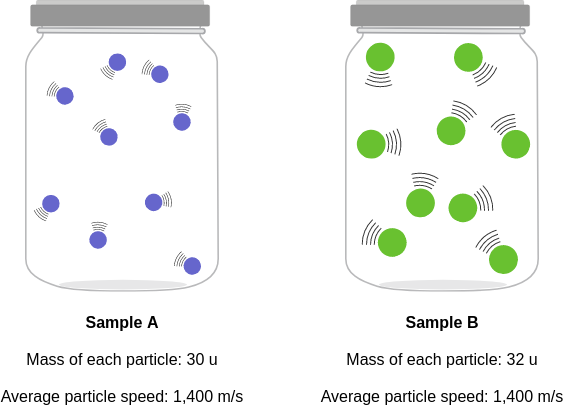

In [46]:
n = 1656
print(filtered_validation_data[n]['question'])
print(filtered_validation_data[n]['hint'])
filtered_validation_data[n]["image"]

Compare the average kinetic energies of the particles in each sample. Which sample has the higher temperature?
The diagrams below show two pure samples of gas in identical closed, rigid containers. Each colored ball represents one gas particle. Both samples have the same number of particles.


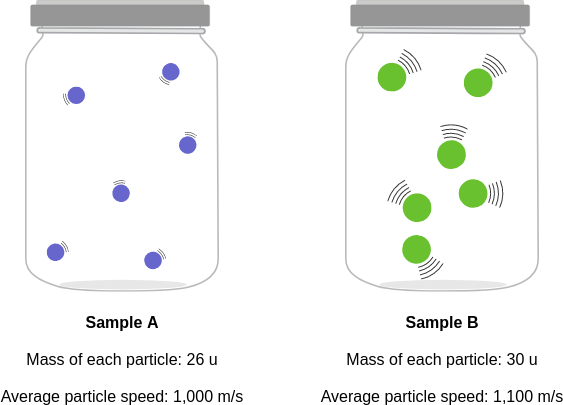

In [47]:
n = 147
print(filtered_validation_data[n]['question'])
print(filtered_validation_data[n]['hint'])
filtered_validation_data[n]["image"]

Compare the average kinetic energies of the particles in each sample. Which sample has the higher temperature?
The diagrams below show two pure samples of gas in identical closed, rigid containers. Each colored ball represents one gas particle. Both samples have the same number of particles.


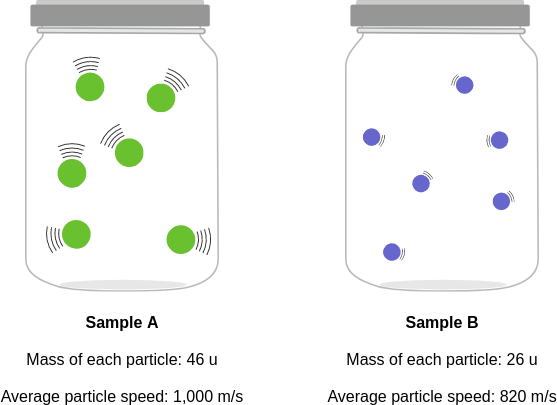

In [48]:
n = 636
print(filtered_validation_data[n]['question'])
print(filtered_validation_data[n]['hint'])
filtered_validation_data[n]["image"]

Compare the average kinetic energies of the particles in each sample. Which sample has the higher temperature?
The diagrams below show two pure samples of gas in identical closed, rigid containers. Each colored ball represents one gas particle. Both samples have the same number of particles.


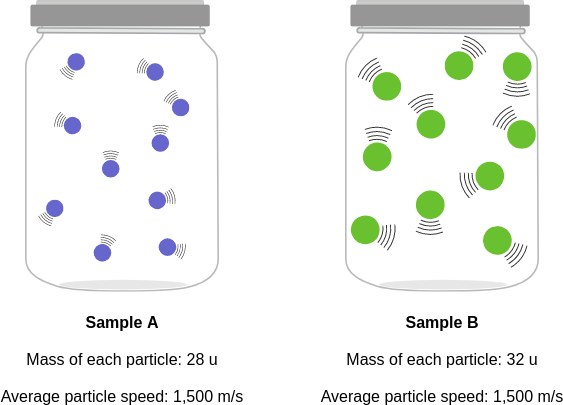

In [49]:
n = 725
print(filtered_validation_data[n]['question'])
print(filtered_validation_data[n]['hint'])
filtered_validation_data[n]["image"]

### Pre-Count

In [23]:
MODEL_NAME = "LLaVAModel1.5-7b"
SETTING = "QTCH"
df = pd.read_csv(f"benchmarking/{MODEL_NAME}/{MODEL_NAME}_val_output_setting_{SETTING}.csv", sep="\t")
answer_pred_col, solution_pred_col = "answer_output", "solution_output"
df[[answer_pred_col, solution_pred_col]] = df["output"].apply(string2json).apply(pd.Series)
# df[answer_pred_col] = df[answer_pred_col].apply(lambda x: int(x))
df[answer_pred_col] = df.apply(lambda row: find_answer_num(row), axis=1)

 No malformed node or string on line 1: <ast.Name object at 0x32db593d0>
 A light spattering of raindrops fell upon the stadium, kissing the fans' cheeks. unterminated string literal (detected at line 1) (<unknown>, line 1)
 'idiom' string indices must be integers, not 'str'
 ['the Bible', 'British history'] list indices must be integers or slices, not str
 {
"answer": "2:2",
"solution": "In a group of koi fish, some individuals have red eyes and others have black eyes. In this group, the gene for the eye color trait has two alleles. The allele for red eyes (E) is dominant over the allele for black eyes (e). The expected ratio of offspring with black eyes to offspring with red eyes is 2:2. This is because the two alleles are in complete linkage, and the expression of the trait is determined by the combination of the two alleles. If one parent has the dominant allele (E), all offspring will have red eyes. If both parents have the recessive allele (e), half of the offspring will have bla

In [24]:
df

,idx,input,output,subject,answer_output,solution_output
0,0,Question: What does the verbal irony in this t...,"{\n""answer"": ""The snoring is loud."",\n""soluti...",language science,0,The verbal irony in the text suggests that the...
1,1,Question: Which animal's mouth is also adapted...,"{\n""answer"": ""sturgeon"",\n""solution"": ""Sturge...",natural science,-1,"Sturgeons eat invertebrates, plants, and small..."
2,0,Question: What does the verbal irony in this t...,"{\n""answer"": ""The snoring is loud."",\n""soluti...",language science,0,The verbal irony in the text suggests that the...
3,1,Question: Which animal's mouth is also adapted...,"{\n""answer"": ""sturgeon"",\n""solution"": ""Sturge...",natural science,-1,"Sturgeons eat invertebrates, plants, and small..."
4,2,Question: Is this a sentence fragment?\nDuring...,No,language science,-1,None
...,...,...,...,...,...,...
3212,3210,Question: What is the source of the allusion i...,"['Greek history', 'a fairy tale']",language science,-1,None
3213,3211,Question: How long is an adult great white sha...,"{\n""answer"": ""6 meters"",\n""solution"": ""A grea...",natural science,2,A great white shark can grow up to 6 meters in...
3214,3212,Question: Which animal is also adapted to be c...,"{\n""answer"": ""Namaqua chameleon"",\n""solution""...",natural science,1,The Namaqua chameleon is also adapted to be ca...
3215,3213,Question: Compare the motion of two fish. Whic...,"{\n""answer"": ""a fish that moved 25kilometers ...",natural science,1,The fish that moved 25kilometers in 5hours was...


In [31]:
df["answer_output"].value_counts()

answer_output
 1    1132
 0    1000
-1     718
 2     302
 3      63
 4       2
Name: count, dtype: int64

In [26]:
df.query("answer_output == -1")

,idx,input,output,subject,answer_output,solution_output
1,1,Question: Which animal's mouth is also adapted...,"{\n""answer"": ""sturgeon"",\n""solution"": ""Sturge...",natural science,-1,"Sturgeons eat invertebrates, plants, and small..."
3,1,Question: Which animal's mouth is also adapted...,"{\n""answer"": ""sturgeon"",\n""solution"": ""Sturge...",natural science,-1,"Sturgeons eat invertebrates, plants, and small..."
4,2,Question: Is this a sentence fragment?\nDuring...,No,language science,-1,None
8,6,Question: Which animal's feet are also adapted...,"{\n""answer"": ""bald eagle"",\n""solution"": ""Bald...",natural science,-1,Bald eagles have sharp talons on their feet th...
10,8,Question: Complete the sentence so that it use...,A light spattering of raindrops fell upon the...,language science,-1,None
...,...,...,...,...,...,...
3174,3172,Question: Which animal's legs are also adapted...,"{\n""answer"": ""shoebill"",\n""solution"": ""Shoebi...",natural science,-1,Shoebills have long legs that are adapted for ...
3181,3179,Question: Which animal's feet are also adapted...,"{\n""answer"": ""Suriname toad"",\n""solution"": ""T...",natural science,-1,The Suriname toad is found in rivers and strea...
3184,3182,Question: Which better describes the Eastern S...,"{\n""answer"": ""It has long, cold winters. It a...",natural science,-1,The Eastern Siberian Taiga is a taiga ecosyste...
3191,3189,Question: Is there a sentence fragment?\nMonke...,No,language science,-1,None


In [57]:
solution_preds =  df[solution_pred_col].tolist()

In [59]:
scores = get_scores(df) #accuracy per subject calculations to evaluate answers
print_scores(scores)

KeyError: 'hint'

In [ ]:
metrics = calculate_metrics_solutions(solution_preds, df) #textual similarity to evaluate solutions
scores.update(metrics)
dict_save = {'model': MODEL_NAME, 'setting': SETTING}
dict_save.update(scores)
df_save = pd.DataFrame(dict_save)
df_save.to_csv(f"{RES_DIR}/{MODEL_NAME}_val_metrics_setting_{i}.csv", sep="\t", encoding="utf-8")

### Count

In [66]:
df

,idx,input,output,subject,answer_output,solution_output
0,0,Question: What does the verbal irony in this t...,"{\n""answer"": ""The snoring is loud."",\n""soluti...",language science,0,The verbal irony in the text suggests that the...
1,1,Question: Which animal's mouth is also adapted...,"{\n""answer"": ""sturgeon"",\n""solution"": ""Sturge...",natural science,-1,"Sturgeons eat invertebrates, plants, and small..."
2,0,Question: What does the verbal irony in this t...,"{\n""answer"": ""The snoring is loud."",\n""soluti...",language science,0,The verbal irony in the text suggests that the...
3,1,Question: Which animal's mouth is also adapted...,"{\n""answer"": ""sturgeon"",\n""solution"": ""Sturge...",natural science,-1,"Sturgeons eat invertebrates, plants, and small..."
4,2,Question: Is this a sentence fragment?\nDuring...,No,language science,-1,None
...,...,...,...,...,...,...
3212,3210,Question: What is the source of the allusion i...,"['Greek history', 'a fairy tale']",language science,-1,None
3213,3211,Question: How long is an adult great white sha...,"{\n""answer"": ""6 meters"",\n""solution"": ""A grea...",natural science,2,A great white shark can grow up to 6 meters in...
3214,3212,Question: Which animal is also adapted to be c...,"{\n""answer"": ""Namaqua chameleon"",\n""solution""...",natural science,1,The Namaqua chameleon is also adapted to be ca...
3215,3213,Question: Compare the motion of two fish. Whic...,"{\n""answer"": ""a fish that moved 25kilometers ...",natural science,1,The fish that moved 25kilometers in 5hours was...


In [136]:
eval("metrics", "LLaVAModel1.5-7b")

Metrics for setting 1 QTCH
Loaded dataframe benchmarking/LLaVAModel1.5-7b/LLaVAModel1.5-7b_val_output_setting_QTCH.csv with 3216 rows
Merged dataframe with metadata has 3216 rows
Expecting value: line 1 column 1 (char 0)
 No
Expecting value: line 1 column 1 (char 0)
 A light spattering of raindrops fell upon the stadium, kissing the fans' cheeks.
Expecting value: line 1 column 1 (char 0)
 'idiom'
Expecting value: line 1 column 2 (char 1)
 ['the Bible', 'British history']
Expecting value: line 1 column 1 (char 0)
 No
Expecting value: line 1 column 2 (char 1)
 ['Dear Grandpa Tim,', 'Dear grandpa Tim,']
Expecting value: line 1 column 1 (char 0)
 The logical fallacy used in the text is "guilt by association: a negative association intended to discredit someone or something".
Expecting value: line 1 column 2 (char 1)
 ['Dear dr. hoffman,', 'Dear Dr. Hoffman,']
Expecting property name enclosed in double quotes: line 1 column 368 (char 367)
 {
"answer": "As they observed the animals on the op